# Airbnb Precios
This is an exploratory analysis of the Airbnb NYC dataset.

The purpose of this notebook is to explore how different components of an Airbnb listing correlate with the price associate with that listing.

This is just a preliminary analysis, but hopefully it encourages you to try some of the methods we introduce here, including geospatial analysis and NLP methods. Even for beginners, it's a great chance to see just how far you can get with some very simple Python functions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import altair as alt
from sklearn.preprocessing import StandardScaler


The Airbnb data is a nicely formatted csv, so we can just read it straight into `pandas`

In [2]:
airbnb = pd.read_csv('AB_NYC_2019.csv')
airbnb = airbnb.dropna(subset=['name'])
airbnb.columns
airbnb

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


Let's plot this data

<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

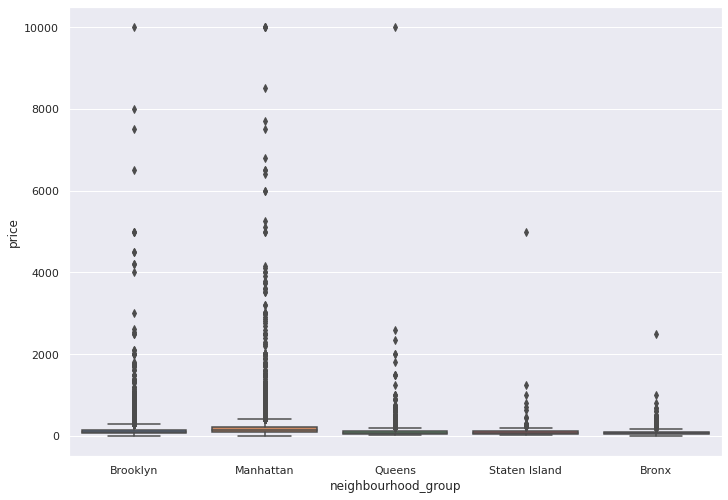

In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
# Vamos a ver precios por grupo de vecindarios
sns.boxplot(data = airbnb, y='price', x = 'neighbourhood_group')

In [4]:
#Vemos muchos outlaiers, vamos a ver un poco mas de cerca los precios por barrios
airbnb.groupby('neighbourhood_group')['price'].describe()[['count','mean', 'std', '50%', 'max']]
# Esto tambien vemos que los datos estan sesgados a la derecha porque la mediana es menos que la media

,count,mean,std,50%,max
neighbourhood_group,,,,,
Bronx,1090.0,87.457798,106.750555,65.0,2500.0
Brooklyn,20098.0,124.395711,186.898953,90.0,10000.0
Manhattan,21652.0,196.877425,291.435503,150.0,10000.0
Queens,5666.0,99.517649,167.102155,75.0,10000.0
Staten Island,373.0,114.812332,277.620403,75.0,5000.0


## Location, location, location
It seems that the famous real estate adage holds true: it's all about location. Median nightly rates in Manhattan are almost double any other borough.

In [5]:
airbnb.groupby('neighbourhood_group').price.describe()[['count','mean','50%','max']]
# Vemos que Manhattan no solo es el mas popular sino que tambien el mas costoso 

,count,mean,50%,max
neighbourhood_group,,,,
Bronx,1090.0,87.457798,65.0,2500.0
Brooklyn,20098.0,124.395711,90.0,10000.0
Manhattan,21652.0,196.877425,150.0,10000.0
Queens,5666.0,99.517649,75.0,10000.0
Staten Island,373.0,114.812332,75.0,5000.0


The neighbourhood is just as important in determining the price. Though both are in Manhattan, the nightly rate in Tribeca is more than quadruple the rate in Washington Heights.

In [6]:
a = airbnb.loc[airbnb.neighbourhood_group == 'Manhattan'].groupby('neighbourhood')['price'].describe()[['count', 'mean', '50%', 'max']]
a.sort_values('50%', ascending=False)

,count,mean,50%,max
neighbourhood,,,,
Tribeca,177.0,490.638418,295.0,8500.0
NoHo,78.0,295.717949,250.0,1795.0
Flatiron District,80.0,341.925000,225.0,2000.0
Midtown,1545.0,282.719094,210.0,5100.0
West Village,768.0,267.682292,200.0,4000.0
Financial District,744.0,225.490591,200.0,3000.0
SoHo,358.0,287.103352,199.0,3000.0
Chelsea,1113.0,249.738544,199.0,6800.0
Greenwich Village,391.0,263.503836,197.0,6000.0


<AxesSubplot:xlabel='price', ylabel='Count'>

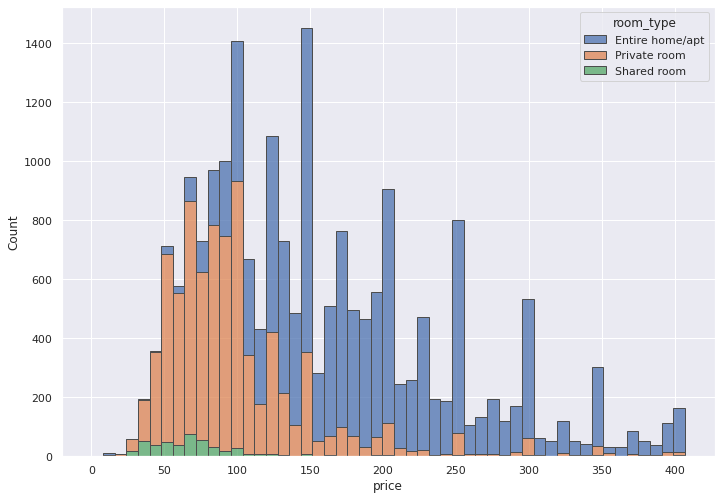

In [7]:
# Vamos a mejorar un poco mas los datso sacando los valores atipicos para mejorar nuestra exploracion de datos
# En este caso vamos con solo Manhattan 
# Quartiles

Q1 = airbnb[airbnb['neighbourhood_group'] == 'Manhattan']['price'].quantile(q = 0.25)
Q3 = airbnb[airbnb['neighbourhood_group'] == 'Manhattan']['price'].quantile(q = 0.75)
iqr_m = Q3 - Q1
minlimit_m = Q1 - 1.5 * iqr_m 
maxlimit_m = Q3 + 1.5 * iqr_m

manhathan = airbnb.loc[(airbnb['neighbourhood_group']=='Manhattan') & (airbnb['price'] <= maxlimit_m)]
# Vemos que es muy efectivo poner cifras cerradas en las publicaciones
sns.histplot(data=manhathan, x='price', hue='room_type', multiple='stack',edgecolor=".3")


## Room type
AirBnB offers everything from shared rooms to entire apartments. We can see that a shared room doesn't't cost much less than a private room, it's only once we upgrade to an entire apartment that the price increases significantly.

In [8]:
tipo = airbnb.groupby('room_type').price.describe()

tipo

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,25402.0,211.788048,284.076979,0.0,120.0,160.0,229.0,10000.0
Private room,22318.0,89.786630,160.232422,0.0,50.0,70.0,95.0,10000.0
Shared room,1159.0,70.075928,101.753942,0.0,33.0,45.0,75.0,1800.0


## Vamos a ver las características de los anfitriones

<AxesSubplot:xlabel='price', ylabel='Count'>

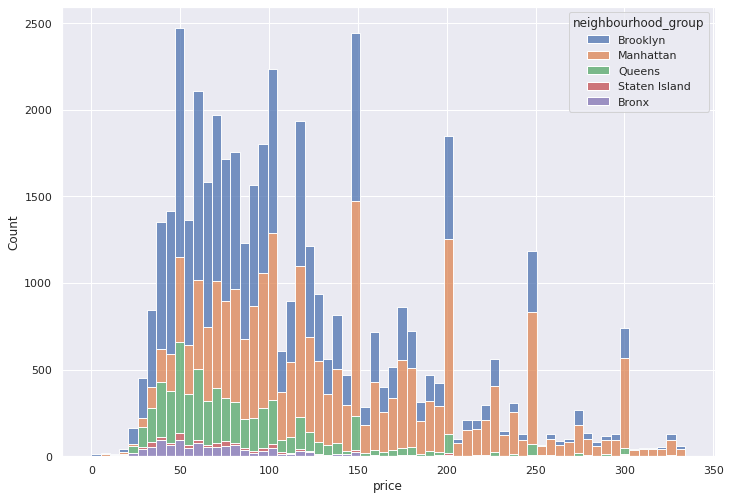

In [9]:
# Vamos a organizar los datos de los outlairs para ver un poco mejor los datos 
Q1 = airbnb['price'].quantile(q = 0.25)
Q3 = airbnb['price'].quantile(q = 0.75)
max_val = airbnb['price'].quantile(q = 1 )
iqr_air = Q3 - Q1
minlimit_air = Q1 - 1.5 * iqr_air
maxlimit_air = Q3 + 1.5 * iqr_air

airbnb_norm = airbnb[(airbnb.price <= maxlimit_air) & (airbnb.price <= maxlimit_air)]
sns.histplot(data=airbnb_norm, x = 'price', hue = 'neighbourhood_group', multiple='stack')
# Algo que seguimos viendo de todos los sectores es que se apoyan fuertemente en el precio de la oferta con 
# numeros cerrados

<AxesSubplot:>

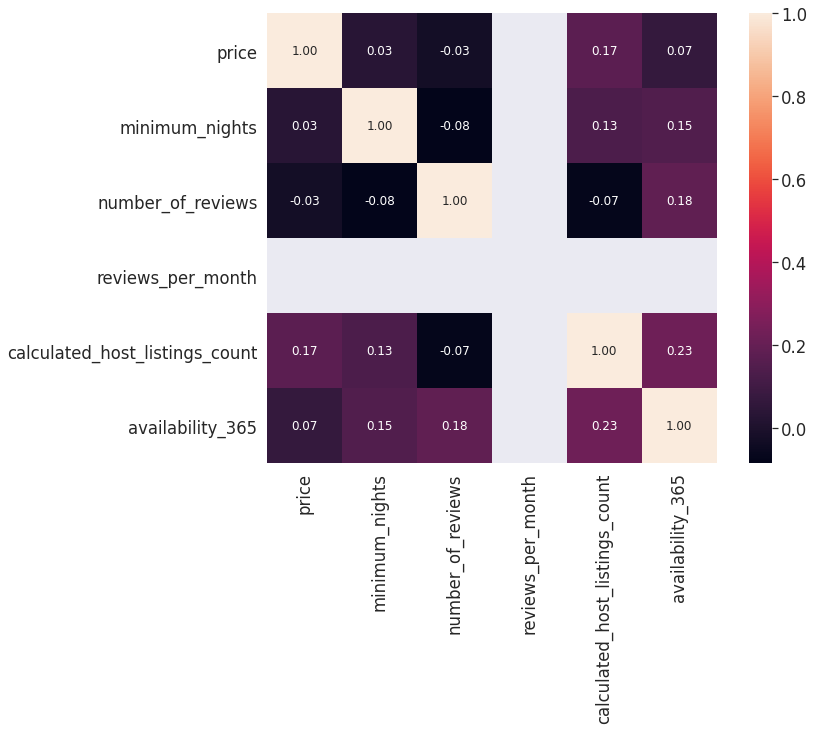

In [10]:
# Vamos a ver al respecto de los anfitriones un poco mas a fondo
# plt.figure(figsize=(10, 10))
sns.set(font_scale=1.5)
# Vamos a escalar los datos a ver que tal nos queda
scaler = StandardScaler()
scaled = scaler.fit_transform(
    airbnb_norm[['price','minimum_nights', 'number_of_reviews', 'reviews_per_month', 
    'calculated_host_listings_count','availability_365']]
)
matrix_covariance = np.cov(scaled.T)
sns.heatmap(matrix_covariance,
                cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 12},
                 yticklabels=['price','minimum_nights', 'number_of_reviews', 'reviews_per_month', 
    'calculated_host_listings_count','availability_365'],
                 xticklabels=['price','minimum_nights', 'number_of_reviews', 'reviews_per_month', 
    'calculated_host_listings_count','availability_365']
                 )

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d0141576-334e-4461-acb2-ff7d1b20738c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>